# Tarea 2 Métodos para Clasificación
---
## Integrantes: 
- *José Eduardo Caimapo* -  jose.caimapo.12@sansano.usm.cl - 201373573-8
- *Rodrigo Sepúlveda* - rodrigo.sepulveda.12@sansano.usm.cl - 201204766-8

# 2. Análisis de audios como datos brutos

En la siguiente sección se estudiará el preprocesamiento de archivos de audio del tipo *.wav*, con el objetivo de poder representar dichos archivos de forma conveniente, y ser utilizados como entrará para algún algoritmo de clasificación. El conjunto de datos a utilizar corresponde a ‘Heartbeat Sounds’ el cual consiste en grabaciones de sonidos de latidos cardíacos, los cuales se clasifican en normales y anormales, donde existen distintas categorías para los latidos anormales. En específico se utilizará el conjunto de datos A, el cual corresponde a datos generados desde la vía pública mediante la aplicación de Iphone iStethoscope Pro. El objetivo del conjunto de datos es clasificar cada grabación como latido cardíaco normal o una de las subcategorías de anormal (Murmur, Extra Heart Sound, Artifact), es decir este conjunto de datos plantea un problema de clasificación múltiple con 4 clases. 

In [1]:
# Imports 
import matplotlib.pyplot  as plt
import numpy              as np
import pandas             as pd

from scipy                          import signal
from scipy.io                       import wavfile
from sklearn.decomposition          import PCA
from sklearn.discriminant_analysis  import LinearDiscriminantAnalysis  as LDA
from sklearn.linear_model           import LogisticRegression            as LR
from sklearn.metrics                import accuracy_score
from sklearn.model_selection        import train_test_split
from sklearn.preprocessing          import StandardScaler
from sklearn.svm                    import SVC                           as SVM
from sklearn.tree                  import DecisionTreeClassifier        as Tree
from ipywidgets                    import interactive

Funciones utilizadas para leer los archivos wav del dataset

In [2]:
def clean_filename(fname, string):
    file_name = fname.split('/')[1]
    if file_name[:2] == '__':
        file_name=string + file_name
    return file_name

SAMPLE_RATE = 44100

def load_wav_file(name, path):
    s, b = wavfile.read(path+name)
    assert s == SAMPLE_RATE
    return b

Función utilizada para determinar el error de un modelo ya entrenado

In [3]:
def eval_model(model, x_data, y_data):
    y_pred = model.predict(x_data)
    loss = 1-accuracy_score(y_data, y_pred)
    return loss

## a) Construya un dataframe con los datos a analizar. Describa el dataset y determine cuántos registros hay por clase.

In [4]:
df = pd.read_csv('data/heartbeat-sounds/set_a.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 4 columns):
dataset     176 non-null object
fname       176 non-null object
label       124 non-null object
sublabel    0 non-null float64
dtypes: float64(1), object(3)
memory usage: 5.6+ KB


,dataset,fname,label,sublabel
0,a,set_a/artifact__201012172012.wav,artifact,NaN
1,a,set_a/artifact__201105040918.wav,artifact,NaN
2,a,set_a/artifact__201105041959.wav,artifact,NaN
3,a,set_a/artifact__201105051017.wav,artifact,NaN
4,a,set_a/artifact__201105060108.wav,artifact,NaN


El conjunto de datos se compone de 176 registros, de los cuales 124 están etiquetados y 52 no lo están. Los registros se componen de la siguiente información:

- dataset: si el registro pertenece al conjunto de grabaciones a o b
- fname: Nombre del archivo de audio
- label: etiqueta del registro, las cuales son: Normal, Murmur, Extra Heart Sound, o Artifact. Si esta en blanco corresponde a un registro sin clasificar.
- sublabel: En el conjunto b, algunas grabaciones están categorizadas como noisy, ya que posen sonidos de fondo no relacionados con los latidos del corazón. Esta etiqueta indica a que corresponden los sonidos de fondo.

En la actividad no se utilizarán las columnas ‘dataset’ y ‘sublabel’, por lo que se eliminan del conjunto de datos.

In [5]:
df = df.drop(['dataset','sublabel'], axis=1)
df.head()

,fname,label
0,set_a/artifact__201012172012.wav,artifact
1,set_a/artifact__201105040918.wav,artifact
2,set_a/artifact__201105041959.wav,artifact
3,set_a/artifact__201105051017.wav,artifact
4,set_a/artifact__201105060108.wav,artifact


In [6]:
df['label'].value_counts()

artifact    40
murmur      34
normal      31
extrahls    19
Name: label, dtype: int64

Finalemte el conjunto de datos cuenta con 40 registros clasificados como artifact, 34 como murmur, 31 como normal,y 19 como extrahls.

## b) Lea los archivos .wav y transformelos en secuencias de tiempo. Realice un padding de ceros al final de cada secuencia para que todas queden representadas con la misma cantidad de elementos, explique la importancia de realizar este paso.

Se define una función que agrega ceros a un arreglo hasta que este tenga un largo definido. 

In [7]:
def padd_zeros(array, length):
    aux = np.zeros(length)
    aux[:array.shape[0]] = array
    return aux

Se procede a leer los archivos wav correspondientes a cada registro, y se aplica padd_zeros a los registros para que todos tengan el mismo largo.

In [8]:
new_df = pd.DataFrame({'file_name' : df['fname'].apply(clean_filename, string='Aunlabelledtest')})
new_df['time_series'] = new_df['file_name'].apply(load_wav_file, path='data/heartbeat-sounds/set_a/')
new_df['len_series']  = new_df['time_series'].apply(len)
new_df['time_series'] = new_df['time_series'].apply(padd_zeros,length=max(new_df['len_series']))
new_df.head()

,file_name,time_series,len_series
0,artifact__201012172012.wav,"[1.0, -3.0, -1.0, -7.0, -9.0, -2.0, -6.0, -5.0...",396900
1,artifact__201105040918.wav,"[-2.0, 3.0, -4.0, 4.0, -3.0, 2.0, -1.0, 0.0, 0...",396900
2,artifact__201105041959.wav,"[6.0, -4.0, -9.0, -1.0, -4.0, 1.0, -5.0, 2.0, ...",396900
3,artifact__201105051017.wav,"[-85.0, -198.0, -214.0, -173.0, -177.0, -206.0...",396900
4,artifact__201105060108.wav,"[53.0, -35.0, 47.0, 170.0, 340.0, 436.0, 535.0...",396900


La razón de realizar un padding de ceros a los registros, es para que todos los registros posean el mismo largo y asi poder utilizar las técnicas de clasificación y recuccion de dimensionalidad ya conocidas. Además, la concadenación por zero_padding aumenta la cantidad de puntos donde se aplica FFT produciendo de esta forma una mejor resolución en la frecuencia. 

Y se visualizan algunos elementos del conjunto de datos

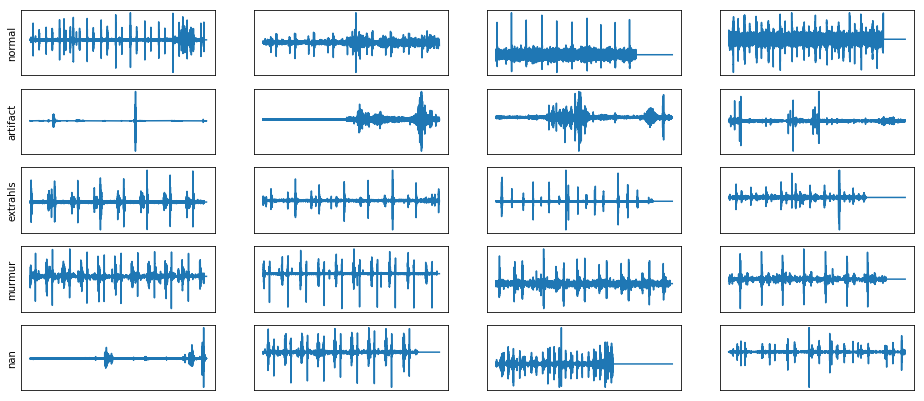

In [9]:
labels = [str(i) for i in set(df['label'])]
img_list = { i:[] for i in set(df['label'])}
list_full = False
i = 0
n_reg = 4

while (not list_full):
    if ( len( img_list[ df['label'][i] ] ) < 10 ):
        img_list[ df['label'][i] ].append(i)
    i += 1
    
    list_full = True
    for j in img_list.keys():
        if len(img_list[j]) < n_reg:
            list_full = False
            break;
            
malper = {0:'normal', 1:'artifact', 2:'extrahls', 3:'murmur', 4:df['label'][140]}
n_lab = len(img_list.keys())
f, axarr = plt.subplots(n_lab, n_reg, figsize=(16,7))
for i in malper:
    for j in range(n_reg):
        v = img_list[malper[i]][j]
        axarr[i,j].plot(new_df['time_series'][v])
        axarr[i,j].get_xaxis().set_visible(False)
        axarr[i,j].get_yaxis().set_visible(False)
    axarr[i,0].set_ylabel( str(malper[i] ) )
    axarr[i,0].get_yaxis().set_visible(True)
    axarr[i,0].get_yaxis().set_ticks([])
plt.show()

## c) Manipule los datos y cambie las etiquetas de los audios por otras asignadas por un doctor experto, el cual afirma que estos cambios son requeridos. Vuelva a determinar cuántos registros hay por clase. Nótese que ahora son 3 clases ¿Explique la problemática de tener etiquetas mal asignadas en los datos? ¿Un solo dato puede afectar esto?

Se procede a reasignar las etiquetas del conjunto de datos, las nuevas etiquetas fueron generadas por un doctor experto, el cual afirma que es conveniente el re etiquetado

In [10]:
new_labels = [
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2,
    2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,
    1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 0,
    2, 2, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0,
    0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2
]


labels = ['artifact', 'normal/extrahls', 'murmur']
new_df['target'] = [labels[i] for i in new_labels]
new_df.info()
new_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 4 columns):
file_name      176 non-null object
time_series    176 non-null object
len_series     176 non-null int64
target         176 non-null object
dtypes: int64(1), object(3)
memory usage: 5.6+ KB


,file_name,time_series,len_series,target
0,artifact__201012172012.wav,"[1.0, -3.0, -1.0, -7.0, -9.0, -2.0, -6.0, -5.0...",396900,artifact
1,artifact__201105040918.wav,"[-2.0, 3.0, -4.0, 4.0, -3.0, 2.0, -1.0, 0.0, 0...",396900,artifact
2,artifact__201105041959.wav,"[6.0, -4.0, -9.0, -1.0, -4.0, 1.0, -5.0, 2.0, ...",396900,artifact
3,artifact__201105051017.wav,"[-85.0, -198.0, -214.0, -173.0, -177.0, -206.0...",396900,artifact
4,artifact__201105060108.wav,"[53.0, -35.0, 47.0, 170.0, 340.0, 436.0, 535.0...",396900,artifact


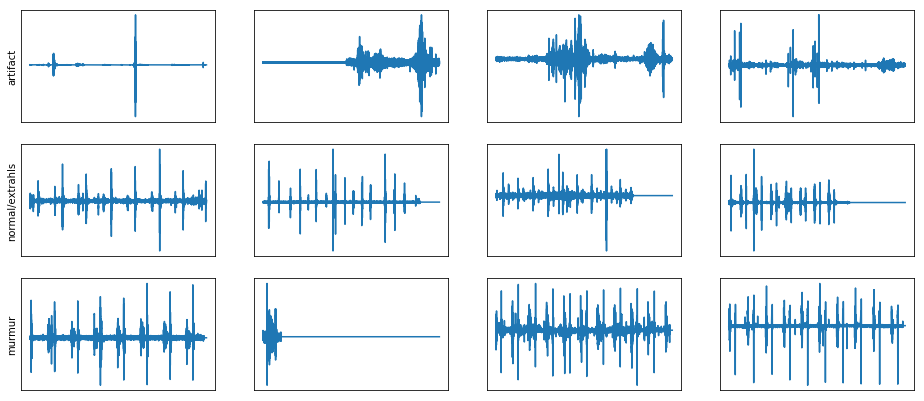

In [11]:
img_list = { i:[] for i in labels }
list_full = False
i = 0
n_reg = 4

while (not list_full):
    if ( len( img_list[ new_df['target'][i] ] ) < 10 ):
        img_list[ new_df['target'][i] ].append(i)
    i += 1
    
    list_full = True
    for j in img_list.keys():
        if len(img_list[j]) < n_reg:
            list_full = False
            break;
            
malper = {0:'artifact', 1:'normal/extrahls', 2:'murmur'}
n_lab = len(img_list.keys())
f, axarr = plt.subplots(n_lab, n_reg, figsize=(16,7))
for i in malper:
    for j in range(n_reg):
        v = img_list[malper[i]][j]
        axarr[i,j].plot(new_df['time_series'][v])
        axarr[i,j].get_xaxis().set_visible(False)
        axarr[i,j].get_yaxis().set_visible(False)
    axarr[i,0].set_ylabel( str(malper[i] ) )
    axarr[i,0].get_yaxis().set_visible(True)
    axarr[i,0].get_yaxis().set_ticks([])
plt.show()

Ha de señalarse que en las nuevas etiquetas del conjunto de datos se incluyen los elementos que no poseían etiqueta originalmente. 

In [12]:
new_df['target'].value_counts()

normal/extrahls    65
artifact           58
murmur             53
Name: target, dtype: int64

Después de aplicar las nuevas etiquetas al conjunto de datos, la cantidad de registros por etiqueta es: 65 para normal/extrahls, 58 para artifact, y 53 para murmur.

Una mala asignación de las etiquetas del conjunto de datos implicaría que el modelo entrenado no sería capaz de aprender correctamente las características de las distintas clases, lo cual provocaría in bajo rendimiento al evaluar el modelo con registros que no pertenecen al conjunto de datos. Lo anterior se debe a que el modelo utiliza las etiquetas para evaluar su estado y determinar qué cambios o elecciones debería hacer para mejorar su rendimiento en el conjunto de entrenamiento para poder converger a una buena solución, y si las etiquetas no están bien asignadas, se convergería a una solución sesgada por la mala elección de las etiquetas. 

Si el modelo se ve drásticamente afectado por la presencia de un elemento, se podría pensar que este no pudo de aprender las características generales del conjunto de datos y aprendió características especificas de algunos elementos, implicando que el modelo presentaría un alto overfiting.

## d) Codifique las distintas clases a valores numéricos para que puedan ser trabajados por los algoritmos clasificadores.

Se codifican las etiquetas a números, para poder utilizar los algoritmos ya implementados en la librería de Sklearn 

In [13]:
new_df["target"] = new_df["target"].astype('category')
cat_columns = new_df.select_dtypes(['category']).columns
new_df[cat_columns] = new_df[cat_columns].apply(lambda x: x.cat.codes)
new_df.head()

,file_name,time_series,len_series,target
0,artifact__201012172012.wav,"[1.0, -3.0, -1.0, -7.0, -9.0, -2.0, -6.0, -5.0...",396900,0
1,artifact__201105040918.wav,"[-2.0, 3.0, -4.0, 4.0, -3.0, 2.0, -1.0, 0.0, 0...",396900,0
2,artifact__201105041959.wav,"[6.0, -4.0, -9.0, -1.0, -4.0, 1.0, -5.0, 2.0, ...",396900,0
3,artifact__201105051017.wav,"[-85.0, -198.0, -214.0, -173.0, -177.0, -206.0...",396900,0
4,artifact__201105060108.wav,"[53.0, -35.0, 47.0, 170.0, 340.0, 436.0, 535.0...",396900,0


## e) Desordene los datos, evitando así el orden en el que vienen la gran mayoría de las etiquetas. Cree la matriz que conformada de los datos en sus dimensiones. ¿Las dimensiones de ésta indican que pueden generarse problemas? ¿De qué tipo?

In [14]:
new_df = new_df.sample(frac=1, random_state=44)
x_data = np.stack(new_df['time_series'].values, axis=0)
y_data = new_df.target.values
x_data.shape

(176, 396900)

Se desordenan los datos, para que estos ya no estén ordenados por etiqueta, con el objetivo de que los modelos creados aprendan de mejor manera las cualidades de los datos, en caso de que estos modelos sean sensibles al orden en que se les presenta la información. Es posible apreciar que las dimensiones de la matriz construida son de 176 filas y 396900 columnas. Dada la alta cantidad de columnas se esperaría que el entrenamiento de los modelos se vea afectado, ya que se necesitaría de un tiempo extremadamente largo para entrenarlos. 

### ¡Observación!
Según la descripción en la documentación de la función de remuestreo,  la cual es:

Resample x to num samples using Fourier method along the given axis.
The resampled signal starts at the same value as x but is sampled with a spacing of len(x) / num * (spacing of x). Because a Fourier method is used, the signal is assumed to be periodic.

El método espera una señal periódica, además de usar el “Fourier method”, por lo que se estimo que era mejor realizar primero el remuestro y después trasformar el conjunto de datos.


## g) Para seguir con el pre procesamiento realice un muestreo representativo de los datos a través de una técnica de muestreo especializada en secuencias ¿En qué beneficia este paso? ¿Cómo podría determinar si el muestro es representativo?

In [68]:
x_resampled = []

for i in range(x_data.shape[0]):
    sequence = x_data[i,:].copy()
    resampled_sequence = signal.resample(sequence, 100000)
    x_resampled.append(resampled_sequence)
    
x_resampled = np.array(x_resampled)
x_resampled.shape

(176, 100000)

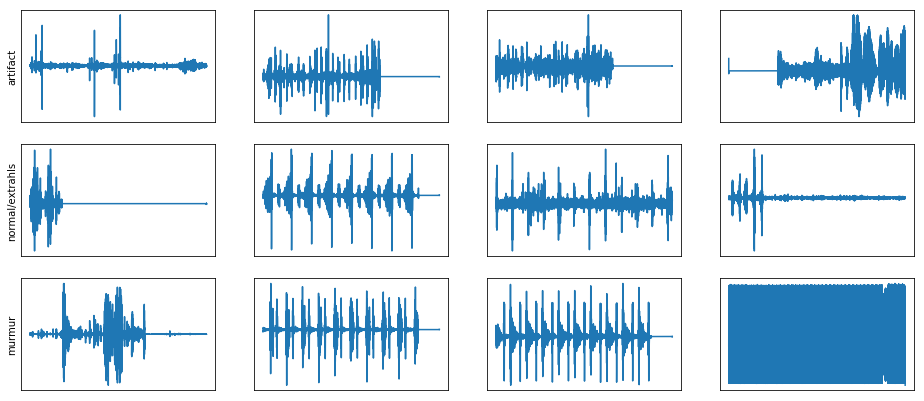

In [69]:
f, axarr = plt.subplots(n_lab, n_reg, figsize=(16,7))
for i in malper:
    for j in range(n_reg):
        v = img_list[malper[i]][j]
        axarr[i,j].plot(x_resampled[v])
        axarr[i,j].get_xaxis().set_visible(False)
        axarr[i,j].get_yaxis().set_visible(False)
    axarr[i,0].set_ylabel( str(malper[i] ) )
    axarr[i,0].get_yaxis().set_visible(True)
    axarr[i,0].get_yaxis().set_ticks([])
plt.show()

Después de realizar el remuestreo, se logró reducir la dimensionalidad de la matriz de entrenamiento a (176, 100000), implicando una reducción del $74.80$ del tamaño de cada registro, lo cual beneficiará el entrenamiento de los modelos a construir. 

El remuestro se considera representativo si se logra representar la distribución del conjunto original en la del conjunto creado. Es decir si las dos muestras presentan la misma probabilidad de que el echo ocurra. 


## f) Para pre procesar la secuencia en el tiempo realice una transformada de fourier discreta  para pasar los datos desde el dominio de tiempos al dominio de frecuencias presentes en la señal de sonido.

In [70]:
x_fourier = np.abs(np.fft.fft(x_resampled))

Se aplica la trasformada de Fourier a la matriz X de los datos, con el objetivo de obtener el espectro de frecuencias de cada registro, ya que el procesamiento de señales la trasformada de Fourier se suele considerar como la descomposición de una señal en componentes de frecuencias diferentes. Además, de acuerdo con la formulación teórica de la trasformada de Fourier, esta cumple con el teorema de Perserval, implicando que la trasformada de Fourier cumple con las cualidades de un operador unitario.

Se grafican algunos de los registros para visualizar el impacto de la trasformada

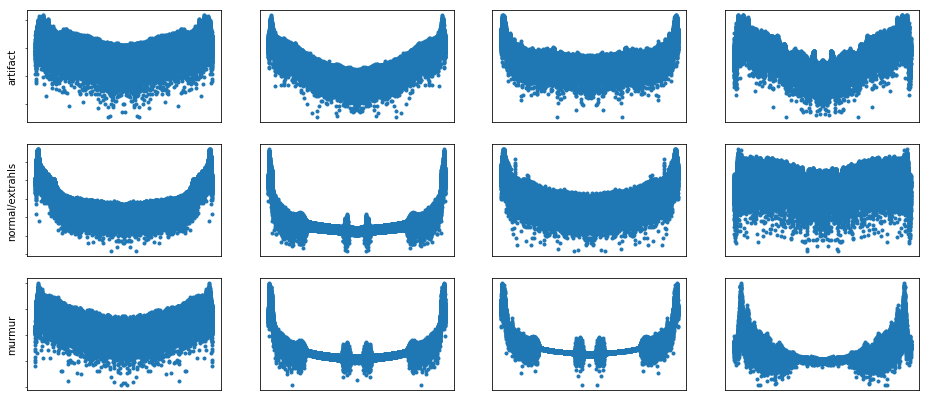

In [71]:
f, axarr = plt.subplots(n_lab, n_reg, figsize=(16,7))
for i in malper:
    for j in range(n_reg):
        v = img_list[malper[i]][j]
        axarr[i,j].plot(x_fourier[v], marker='.', linestyle='')
        axarr[i,j].get_xaxis().set_visible(False)
        axarr[i,j].get_yaxis().set_visible(False)
        axarr[i,j].set_yscale('symlog')
    axarr[i,0].set_ylabel( str(malper[i] ) )
    axarr[i,0].get_yaxis().set_visible(True)
    axarr[i,0].get_yaxis().set_ticks([])
plt.show()

Después de aplicar la trasformada de Fourier, se aprecia que los registros poseen un eje de simetría en eje $X=\alpha$, donde $\alpha$ corresponde a un valor adecuado. 

## h) Genere un conjunto de pruebas mediante la técnica hold-out validation para verificar la calidad de los clasificadores. ¿Cuántas clases tiene y de qué tamaño queda cada conjunto?


In [99]:
x_train, x_test, y_train, y_test = train_test_split(x_fourier, y_data, test_size=0.25)

Se crean los conjuntos de entrenamiento y pruebas. El conjunto de pruebas corresponde al 25% del conjunto de datos.

In [100]:
unique, counts = np.unique(y_train, return_counts=True)
for i in range(counts.size):
    print('%s: %d\t' % (labels[unique[i]], counts[i]), end = '')

artifact: 47	normal/extrahls: 37	murmur: 48	

El conjunto de entrenamiento se compone de 132 datos y posee 45 datos etiquetados como artifact, 36 como normal/extrahls, y 51 como murmur.

In [101]:
unique, counts = np.unique(y_test, return_counts=True)
for i in range(counts.size):
    print('%s: %d\t' % (labels[unique[i]], counts[i]), end = '')

artifact: 11	normal/extrahls: 16	murmur: 17	

El conjunto de pruebas se compone de 44 datos y pose 13 elementos de la etiqueta artifact, 17 como normal/extrahls, y 14 como murmur.

## i)  Realice un proceso de estandarizar los datos para ser trabajados adecuadamente. Recuerde que solo se debe ajustar (calcular media y desviación estándar) con el conjunto de entrenamiento.

In [102]:
std = StandardScaler(with_mean=True, with_std=True)
std.fit(x_train)
x_train = std.transform(x_train)
x_test = std.transform(x_test)

## j) Realice una reducción de dimensionalidad a través de la técnica PCA, para representar los datos en d = 2 dimensiones. Recuerde que solo se debe ajustar (encontrar las componentes principales) con el conjunto de entrenamiento. Visualice apropiadamente la proyección en 2 dimensiones.

In [103]:
d=2
pca_model = PCA(n_components=d)
pca_model.fit(x_train)
x_pca_train = pca_model.transform(x_train)
x_pca_test = pca_model.transform(x_test)

Se reduce la dimensionalidad a dos dimensiones, de los conjuntos de entrenamiento y pruebas utilizando PCA. Para visualizar correctamente lo realizado por la trasformación se grafica el conjunto reducido en un grafico 2D, como se muestra a continuación: 

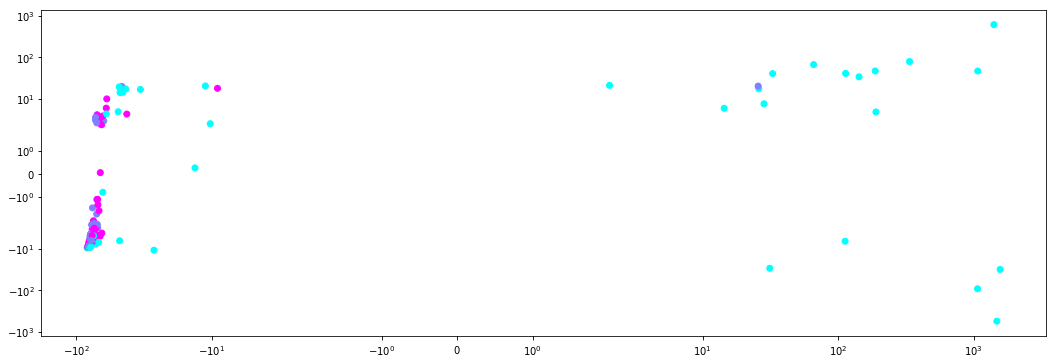

In [104]:
plt.figure(figsize=(18,6))
plt.scatter(x_pca_train[:,0],x_pca_train[:,1], c=y_train, cmap=plt.cm.cool)
plt.xscale('symlog')
plt.yscale('symlog')
plt.show()

Los ejes de grafico están en escala logarítmica (symlog) debido a las grandes diferencias entre algunos elementos del conjunto reducido. Y se realiza un Zoom a la zona de mayor concentración de puntos:

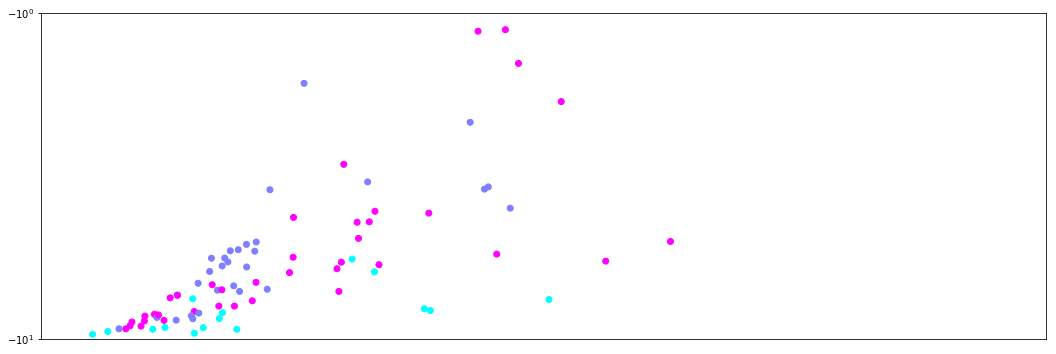

In [105]:
plt.figure(figsize=(18,6))
plt.scatter(x_pca_train[:,0],x_pca_train[:,1], c=y_train, cmap=plt.cm.cool)
plt.xscale('symlog')
plt.yscale('symlog')
plt.axis((-85, -55, -10, -1))
plt.show()

## k) Entrene un modelo de Regresión Logística variando el parámetro de regularizacion C construyendo un gráfico resumen del error en función de este hiper-parámetro. Además entrene una Máquina de Soporte Vectorial (SVM) con kernel lineal, variando el hiper-parámetro de regularizacion C en el mismo rango que para la Regresión Logística, construyendo el mismo gráfico resumen. Compare.

In [107]:
n_try = 100
C_param = np.logspace(-4,4,base=10, num=n_try)

lr_model=LR() 
error_lr_train = []
error_lr_test = []

svm_model = SVM()
error_svm_train = []
error_svm_test = []

for i in C_param:
    print('tain whit c='+str(i), end='\r')
    # LR
    lr_model.set_params(C=i, penalty='l2')
    lr_model.fit(x_pca_train, y_train)
    error_lr_train.append( eval_model(lr_model, x_pca_train, y_train))
    error_lr_test.append(  eval_model(lr_model, x_pca_test,  y_test) )
    
    # SVM
    svm_model.set_params(C=i, kernel='linear')
    svm_model.fit(x_pca_train, y_train)
    error_svm_train.append(eval_model(svm_model, x_pca_train, y_train))
    error_svm_test.append( eval_model(svm_model, x_pca_test, y_test)  )    

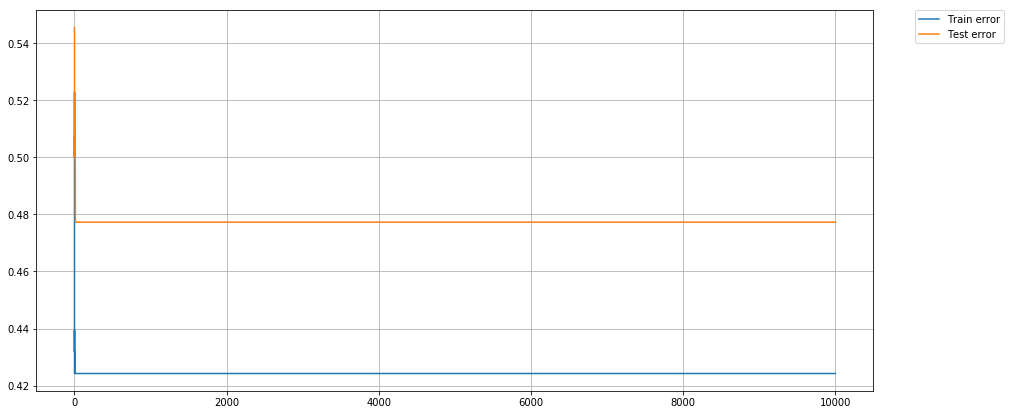

In [114]:
plt.figure(figsize=(15,7))
plt.plot(C_param, error_lr_train, label='Train error')
plt.plot(C_param, error_lr_test, label='Test error')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

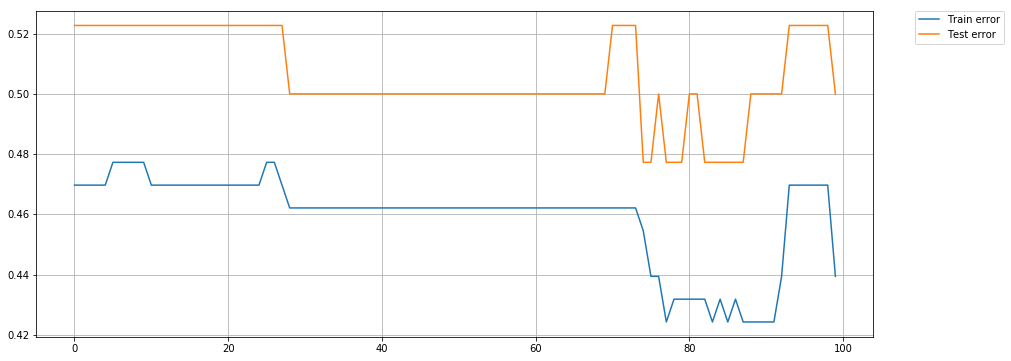

In [117]:
plt.figure(figsize=(15,6))
plt.plot(error_svm_train, label='Train error')
plt.plot(error_svm_test, label='Test error')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## l) Entrene un Arbol de Decisión, con la configuración que estime conveniente, variando el hiper-parámetro regularizador max depth, construyendo un gráfico resumen del error en función de este parámetro. Compare con los modelos anteriores.

In [118]:
n_try = 10
C_param = range(1, n_try*2+1)

tree_model= Tree()
error_tgini_train = []
error_tgini_test = []
error_tentropy_train = []
error_tentropy_test = []

for i in C_param:
    # Tree - gini
    tree_model.set_params(max_depth=i, criterion='gini', splitter='best')
    tree_model.fit(x_pca_train, y_train)
    error_tgini_train.append( eval_model(tree_model, x_pca_train, y_train) )
    error_tgini_test.append( eval_model(tree_model, x_pca_test, y_test) )
    
    # Tree - entropy
    tree_model.set_params(criterion='entropy', splitter='best')
    tree_model.fit(x_pca_train, y_train)
    error_tentropy_train.append( eval_model(tree_model, x_pca_train, y_train) )
    error_tentropy_test.append( eval_model(tree_model, x_pca_test, y_test) )

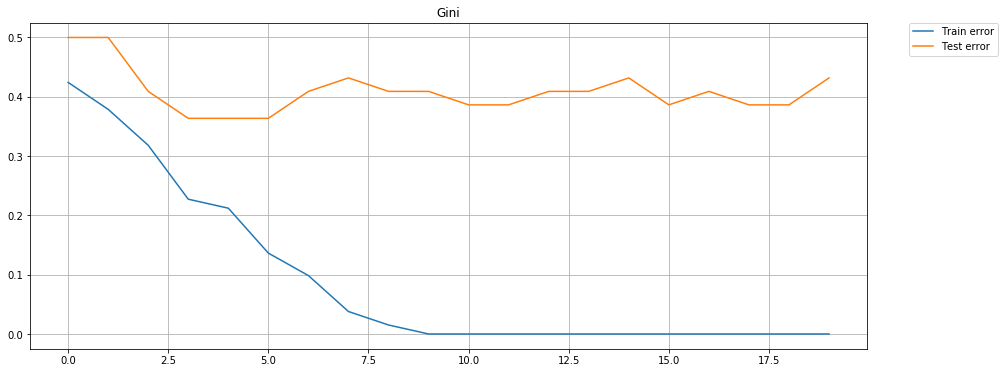

In [121]:
plt.figure(figsize=(15,6))
plt.plot(error_tgini_train, label='Train error')
plt.plot(error_tgini_test, label='Test error')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Gini')
plt.show()

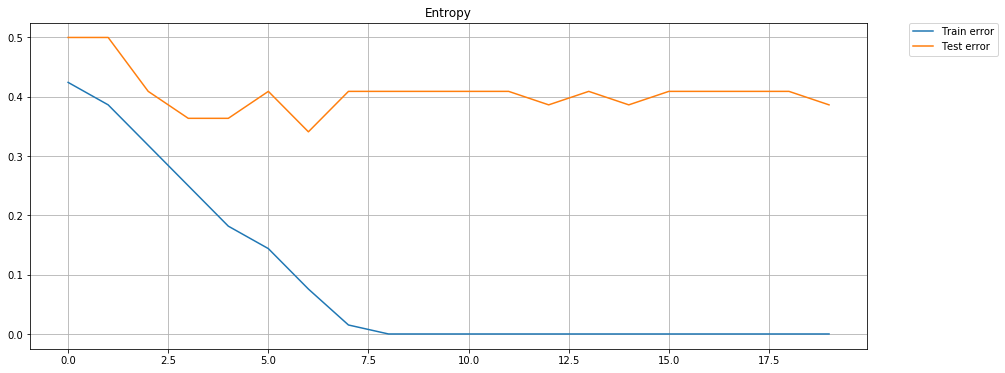

In [122]:
plt.figure(figsize=(15,6))
plt.plot(error_tentropy_train, label='Train error')
plt.plot(error_tentropy_test, label='Test error')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Entropy')
plt.show()

## m) Experimente con diferentes dimensiones d para la proyección de PCA con el propósito de obtener un modelo con menor error. Construya una tabla o gráfico resumen.

In [123]:
error_lr_test = []
error_lr_train = []
error_pca_test = []
error_pca_train = []
error_tgini_train = []
error_tgini_test = []
error_tentropy_train = []
error_tentropy_test = []

lr_model=LR()
svm_model=SVM(probability=True)
tree_model= Tree()

for d in range(1, 75):
    _pca_model = PCA(n_components=d)
    _pca_model.fit(x_train)
    _x_pca_train = _pca_model.transform(x_train)
    _x_pca_test = _pca_model.transform(x_test)

    # LR
    lr_model.set_params(penalty='l2')
    lr_model.fit(_x_pca_train, y_train)
    error_lr_train.append( eval_model(lr_model, _x_pca_train, y_train) )
    error_lr_test.append( eval_model(lr_model, _x_pca_test, y_test) )
    
    # SVM
    svm_model.set_params(kernel='linear')
    svm_model.fit(_x_pca_train, y_train)
    error_pca_train.append( eval_model(svm_model, _x_pca_train, y_train) )
    error_pca_test.append( eval_model(svm_model, _x_pca_test, y_test) )
    
    # Tree - gini
    tree_model.set_params(criterion='gini', splitter='best')
    tree_model.fit(_x_pca_train, y_train)
    error_tgini_train.append( eval_model(tree_model, _x_pca_train, y_train) )
    error_tgini_test.append( eval_model(tree_model, _x_pca_test, y_test) )
    
    # Tree - entropy
    tree_model.set_params(criterion='entropy', splitter='best')
    tree_model.fit(_x_pca_train, y_train)
    error_tentropy_train.append( eval_model(tree_model, _x_pca_train, y_train) )
    error_tentropy_test.append( eval_model(tree_model, _x_pca_test, y_test) )
    
    if (d%4==0 or d==1):
        print('d=%d - EtLR: %.2f, EtrLR: %.2f - EtSVM: %.2f, EtrSVM: %.2f - EtTg: %.2f, EtrTg: %.2f - EtTe: %.2f, EtrTe: %.2f' 
          % (d, error_lr_train[d-1], error_lr_test[d-1],
                error_pca_train[d-1], error_pca_test[d-1], 
                error_tgini_train[d-1], error_tgini_test[d-1],
                error_tentropy_train[d-1], error_tentropy_test[d-1]))

d=1 - EtLR: 0.42, EtrLR: 0.50 - EtSVM: 0.42, EtrSVM: 0.50 - EtTg: 0.00, EtrTg: 0.45 - EtTe: 0.00, EtrTe: 0.45
d=4 - EtLR: 0.41, EtrLR: 0.43 - EtSVM: 0.27, EtrSVM: 0.16 - EtTg: 0.00, EtrTg: 0.32 - EtTe: 0.00, EtrTe: 0.32
d=8 - EtLR: 0.28, EtrLR: 0.18 - EtSVM: 0.17, EtrSVM: 0.18 - EtTg: 0.00, EtrTg: 0.34 - EtTe: 0.00, EtrTe: 0.27
d=12 - EtLR: 0.20, EtrLR: 0.16 - EtSVM: 0.12, EtrSVM: 0.11 - EtTg: 0.00, EtrTg: 0.30 - EtTe: 0.00, EtrTe: 0.27
d=16 - EtLR: 0.17, EtrLR: 0.11 - EtSVM: 0.15, EtrSVM: 0.11 - EtTg: 0.00, EtrTg: 0.23 - EtTe: 0.00, EtrTe: 0.32
d=20 - EtLR: 0.17, EtrLR: 0.11 - EtSVM: 0.14, EtrSVM: 0.14 - EtTg: 0.00, EtrTg: 0.32 - EtTe: 0.00, EtrTe: 0.32
d=24 - EtLR: 0.15, EtrLR: 0.14 - EtSVM: 0.10, EtrSVM: 0.11 - EtTg: 0.00, EtrTg: 0.32 - EtTe: 0.00, EtrTe: 0.27
d=28 - EtLR: 0.14, EtrLR: 0.11 - EtSVM: 0.11, EtrSVM: 0.14 - EtTg: 0.00, EtrTg: 0.32 - EtTe: 0.00, EtrTe: 0.27
d=32 - EtLR: 0.13, EtrLR: 0.09 - EtSVM: 0.07, EtrSVM: 0.14 - EtTg: 0.00, EtrTg: 0.32 - EtTe: 0.00, EtrTe: 0.25
d=36

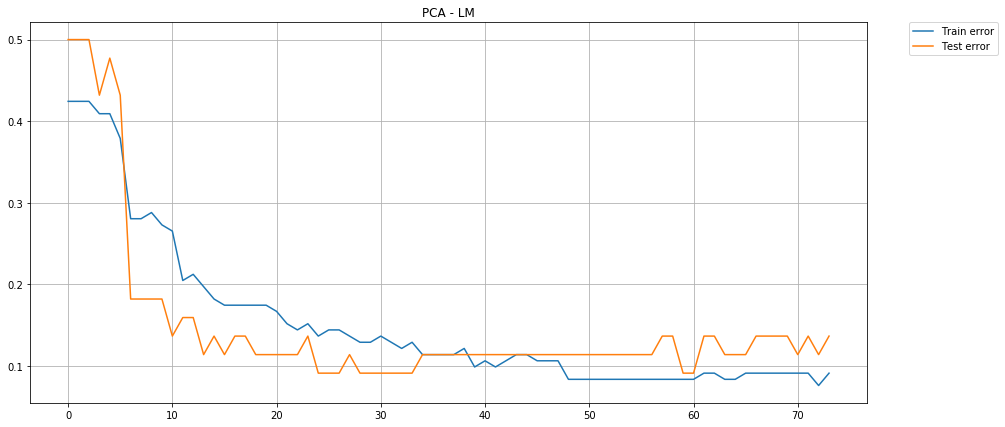

In [131]:
plt.figure(figsize=(15,7))
plt.plot(error_lr_train, label='Train error')
plt.plot(error_lr_test, label='Test error')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('PCA - LM')
plt.show()

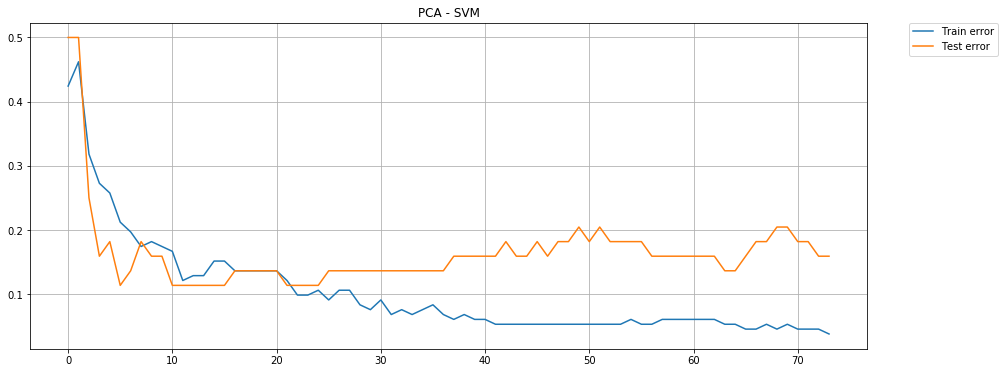

In [127]:
plt.figure(figsize=(15,6))
plt.plot(error_pca_train, label='Train error')
plt.plot(error_pca_test, label='Test error')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('PCA - SVM')
plt.show()

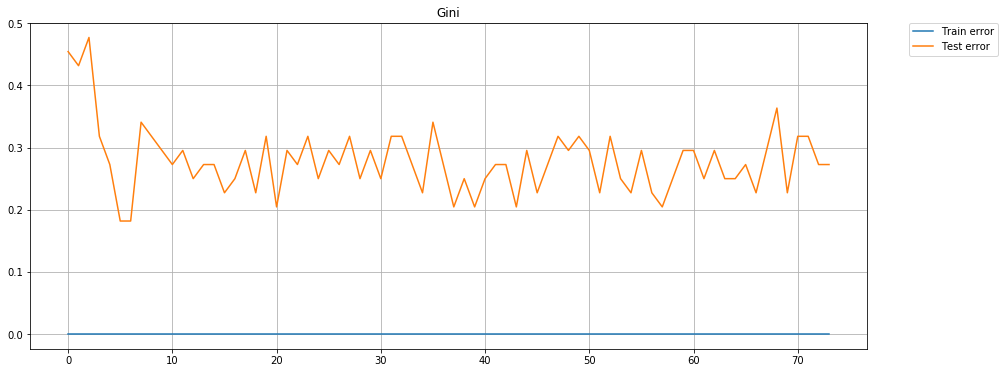

In [125]:
plt.figure(figsize=(15,6))
plt.plot(error_tgini_train, label='Train error')
plt.plot(error_tgini_test, label='Test error')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Gini')
plt.show()

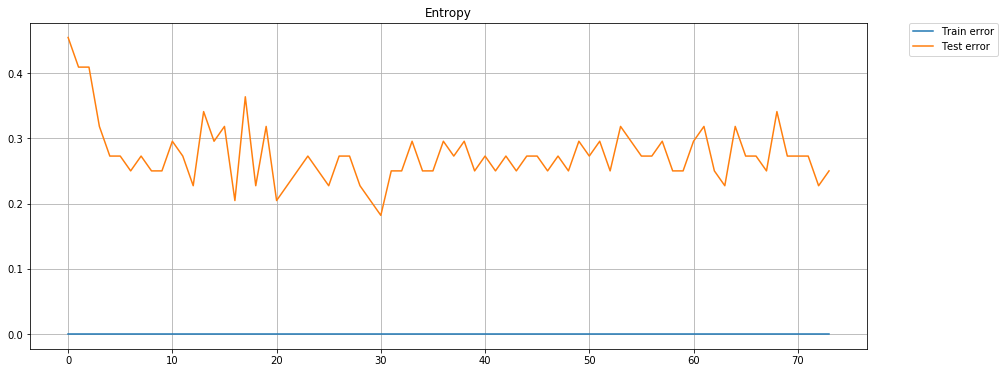

In [124]:
plt.figure(figsize=(15,6))
plt.plot(error_tentropy_train, label='Train error')
plt.plot(error_tentropy_test, label='Test error')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Entropy')
plt.show()

## n) Realice otra reducción de dimensionalidad ahora a través de la técnica LDA, para representar los datos en d = 2 dimensiones. Recuerde que sólo se debe ajustar con el conjunto de entrenamiento, si semmuestra un warning explique el porqué. Visualice apropiadamente la proyección en 2 dimensiones.

In [132]:
lda_model = LDA(n_components=2)
lda_model.fit(x_train, y_train)
x_lda_train = lda_model.transform(x_train)
x_lda_test = lda_model.transform(x_test)

C:\Users\tres1\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


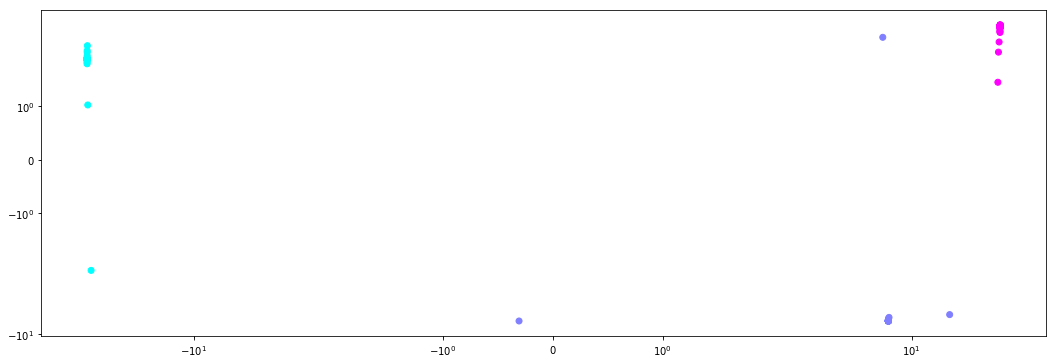

In [135]:
plt.figure(figsize=(18,6))
plt.scatter(x_lda_train[:,0],x_lda_train[:,1], c=y_train, cmap=plt.cm.cool)
plt.xscale('symlog')
plt.yscale('symlog')
plt.show()

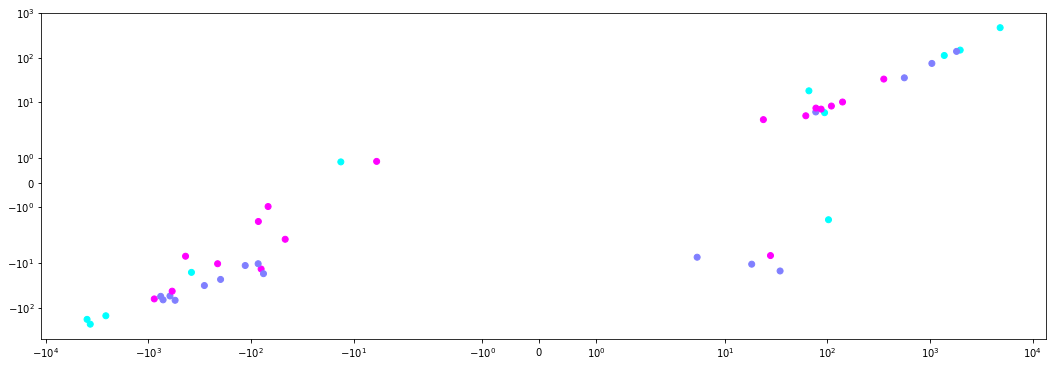

In [136]:
plt.figure(figsize=(18,6))
plt.scatter(x_lda_test[:,0],x_lda_test[:,1], c=y_test, cmap=plt.cm.cool)
plt.xscale('symlog')
plt.yscale('symlog')
plt.show()

## o) Con el propósito de encontrar el mejor modelo vuelva a realizar el item h) con el i) en el nuevo espacio generado por la representaciçón según las d dimensiones de la proyección LDA. Esta nueva representación ¿mejora o empeora el desempeño? Explique.

In [137]:
n_try = 100
C_param = np.logspace(-4,4,base=10, num=n_try)

lr_model=LR() 
error_lr_train = []
error_lr_test = []

svm_model = SVM()
error_svm_train = []
error_svm_test = []

for i in C_param:
    print('tain whit c='+str(i), end='\r')
    # LR
    lr_model.set_params(C=i, penalty='l2')
    lr_model.fit(x_lda_train, y_train)
    error_lr_train.append( eval_model(lr_model, x_lda_train, y_train))
    error_lr_test.append(  eval_model(lr_model, x_lda_test,  y_test) )
    
    # SVM
    svm_model.set_params(C=i, kernel='linear')
    svm_model.fit(x_pca_train, y_train)
    error_svm_train.append(eval_model(svm_model, x_lda_train, y_train))
    error_svm_test.append( eval_model(svm_model, x_lda_test, y_test)  )  

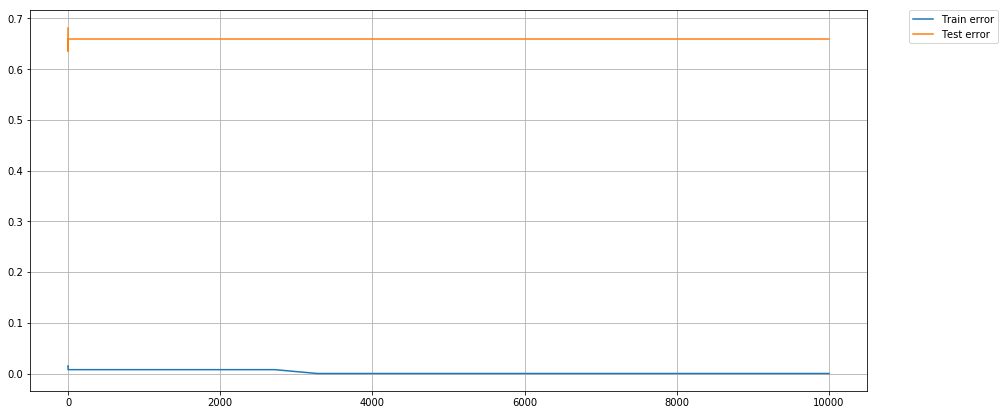

In [138]:
plt.figure(figsize=(15,7))
plt.plot(C_param, error_lr_train, label='Train error')
plt.plot(C_param, error_lr_test, label='Test error')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

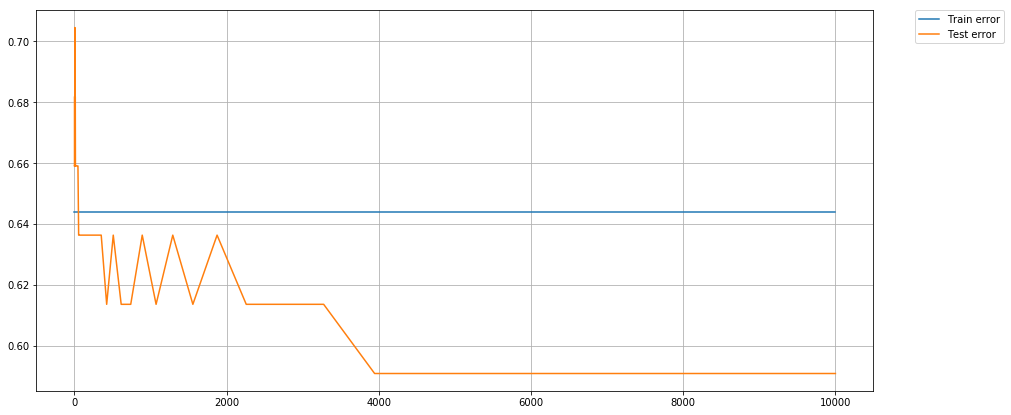

In [139]:
plt.figure(figsize=(15,7))
plt.plot(C_param, error_svm_train, label='Train error')
plt.plot(C_param, error_svm_test, label='Test error')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [140]:
n_try = 20
C_param = range(1, n_try+1)

tree_model= Tree()
error_tgini_train = []
error_tgini_test = []
error_tentropy_train = []
error_tentropy_test = []

for i in C_param:
    # Tree - gini
    tree_model.set_params(max_depth=i, criterion='gini', splitter='best')
    tree_model.fit(x_lda_train, y_train)
    error_tgini_train.append( eval_model(tree_model, x_lda_train, y_train) )
    error_tgini_test.append( eval_model(tree_model, x_lda_test, y_test) )
    
    # Tree - entropy
    tree_model.set_params(criterion='entropy', splitter='best')
    tree_model.fit(x_lda_train, y_train)
    error_tentropy_train.append( eval_model(tree_model, x_lda_train, y_train) )
    error_tentropy_test.append( eval_model(tree_model, x_lda_test, y_test) )

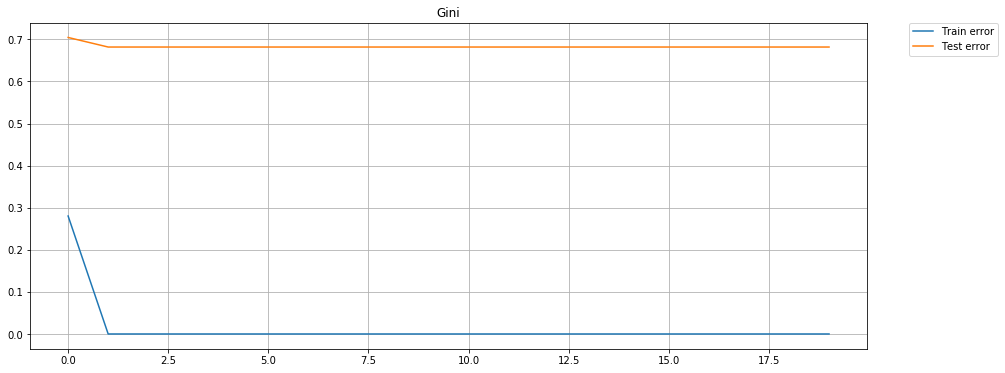

In [143]:
plt.figure(figsize=(15,6))
plt.plot(error_tgini_train, label='Train error')
plt.plot(error_tgini_test, label='Test error')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Gini')
plt.show()

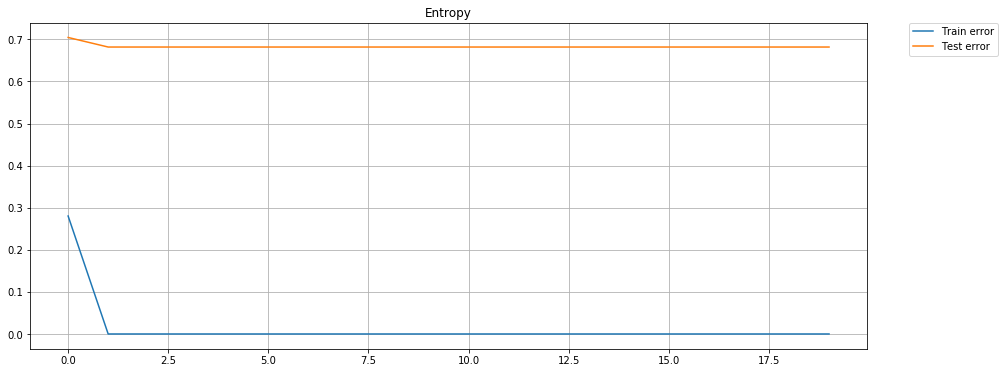

In [141]:
plt.figure(figsize=(15,6))
plt.plot(error_tentropy_train, label='Train error')
plt.plot(error_tentropy_test, label='Test error')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Entropy')
plt.show()

## p) Intente mejorar el desempeño de los algoritmos ya entrenados. Diseñe ahora sus propias cracterísticas (feature crafting) a partir de los datos brutos (secuencia de amplitudes), puede inspirarse en otros trabajos si desea.

Se intenta usar un Autoencoder como reductor de dimensionalidad.

In [167]:
from keras.layers import Input, Dense, Dropout, Flatten
from keras.models import Model, Sequential
from sklearn.manifold import TSNE

In [173]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(x_data, y_data, test_size=0.25)

In [175]:
input_img = Input(shape=x_data[0].shape)
d_ = 2
act_functions = ('sigmoid', 'sigmoid')
    
encoded = Dense(d_, activation=act_functions[0])(input_img)
    
decoded = Dense(396900, activation=act_functions[1])(encoded)
    

autoencoder = Model(input=input_img, output=decoded)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
history = autoencoder.fit(x_train2, x_train2,
              epochs=25,
              batch_size=256,
              shuffle=True,
              verbose=1,
              validation_data=(x_test2, x_test2))

C:\Users\tres1\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # Remove the CWD from sys.path while we load stuff.


Train on 132 samples, validate on 44 samples
Epoch 1/25
132/132 [==============================] - 13s 102ms/step - loss: 0.6902 - val_loss: 0.7088
Epoch 2/25
132/132 [==============================] - 6s 47ms/step - loss: 7.5246e-04 - val_loss: 0.7165
Epoch 3/25
132/132 [==============================] - 6s 44ms/step - loss: -0.7096 - val_loss: 0.7271
Epoch 4/25
132/132 [==============================] - 6s 46ms/step - loss: -1.3205 - val_loss: 0.7333
Epoch 5/25
132/132 [==============================] - 6s 45ms/step - loss: -1.9020 - val_loss: 0.7471
Epoch 6/25
132/132 [==============================] - 6s 45ms/step - loss: -2.6296 - val_loss: 0.7642
Epoch 7/25
132/132 [==============================] - 6s 42ms/step - loss: -3.4219 - val_loss: 0.7771
Epoch 8/25
132/132 [==============================] - 6s 43ms/step - loss: -4.2300 - val_loss: 0.7886
Epoch 9/25
132/132 [==============================] - 8s 64ms/step - loss: -4.9736 - val_loss: 0.8003
Epoch 10/25
132/132 [============

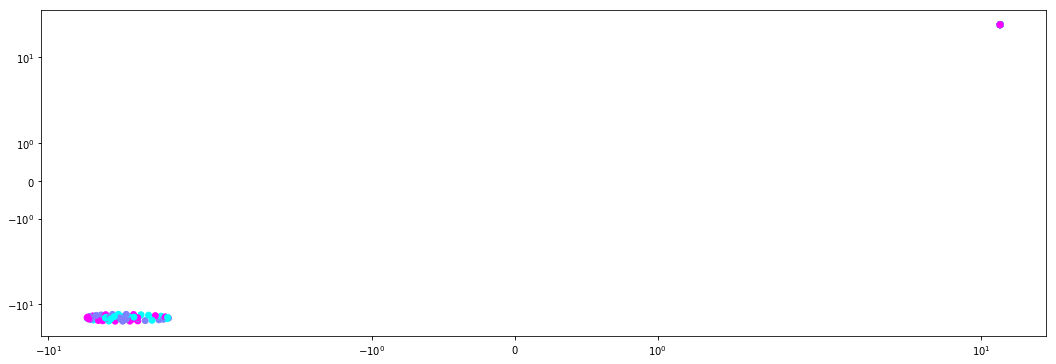

In [176]:
model = TSNE(n_components=2, random_state=0)

encoded_train = autoencoder.predict(x_train2)
encoded_train = model.fit_transform(encoded_train)

plt.figure(figsize=(18,6))
plt.scatter(encoded_train[:,0], encoded_train[:,1], c=y_train, cmap=plt.cm.cool)
plt.xscale('symlog')
plt.yscale('symlog')
plt.show()

In [181]:
n_try = 20
C_param = np.logspace(-4,4,base=10, num=n_try)

lr_model=LR() 
error_lr_train = []
error_lr_test = []

svm_model = SVM()
error_svm_train = []
error_svm_test = []

for i in C_param:
    print('tain whit c='+str(i), end='\r')
    # LR
    lr_model.set_params(C=i, penalty='l2')
    lr_model.fit(x_pca_train, y_train)
    error_lr_train.append( eval_model(lr_model, encoded_train, y_train))
    #error_lr_test.append(  eval_model(lr_model, x_pca_test,  y_test) )
    
    # SVM
    svm_model.set_params(C=i, kernel='linear')
    svm_model.fit(x_pca_train, y_train)
    error_svm_train.append(eval_model(svm_model, encoded_train, y_train))
    #error_svm_test.append( eval_model(svm_model, x_pca_test, y_test)  )    

In [184]:
error_lr_test

[]

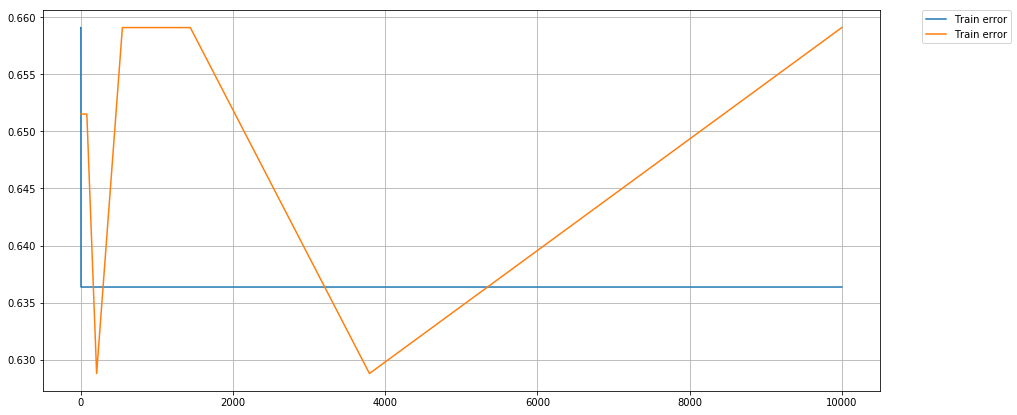

In [186]:
plt.figure(figsize=(15,7))
plt.plot(C_param, error_lr_train, label='Train error')
plt.plot(C_param, error_svm_train, label='Train error')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()